# Highly-multiplexed image analysis with Harpy

In this notebook we will import an unprocessed spatial proteomics dataset from the MACSima platform and perform some cell segmentation and feature calculation using Harpy.


In [1]:
# To run this notebook with CUDA, install dask-cuda:
#    uv pip install dask-cuda==24.12.0
#
# We pin to this version because spatialdata requires
# dask>=2024.10.0,<=2024.11.2, and dask-cuda 24.12.0
# is the latest release compatible with that range.

from matplotlib import pyplot as plt

import harpy as hp

## 1. Load the example dataset

The example dataset for this notebook will be downloaded and cached using `pooch` via `harpy.dataset.registry`. The dataset is a small subset of a larger dataset that was generated using the MACSima platform.


In [2]:
sdata = hp.datasets.macsima_example()
sdata

/Users/arnedf/VIB/harpy/.venv_harpy_1_12_25/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


WARNING  Module 'bioio' is not installed. Install it with `pip install bioio` to use `harpy.io.macsima`.           
WARNING  Module 'bioio-ome-tiff' is not installed. Install it with `pip install bioio-ome-tiff` to use             
         `harpy.io.macsima`.                                                                                       


/Users/arnedf/VIB/harpy/src/harpy/datasets/proteomics.py:33: UserWarning: SpatialData is not stored in the most current format. If you want to use Zarr v3, please write the store to a new location using `sdata.write()`.
  sdata = read_zarr(os.path.commonpath(unzip_path))
2025-12-02 11:31:41,110 - harpy.image._manager - INFO - Writing results to layer 'HumanLiverH35'


SpatialData object
└── Images
      └── 'HumanLiverH35': DataArray[cyx] (151, 1000, 1000)
with coordinate systems:
    ▸ 'global', with elements:
        HumanLiverH35 (Images)

Spatial proteomics usually differs from spatial transcriptomics in that the data is mostly highly-multiplexed images instead of just a cell staining and gene transcript locations. In this subsetted example dataset we have an image of 1000 by 1000 pixels and 151 channels from 51 staining rounds. With one DAPI stain per round, there are 100 markers of interest.


In [3]:
marker_names = sdata["HumanLiverH35"].coords["c"].values.tolist()
print(len(marker_names))
", ".join(marker_names)

151


'R0_DAPI, R1_DAPI, R1_VSIG4, R1_CD14, R2_DAPI, R2_CD163, R3_DAPI, R3_CD11c, R3_CD335, R4_DAPI, R4_CD141, R5_DAPI, R5_CD169, R5_CD49d, R6_DAPI, R6_CD279, R7_DAPI, R7_CD4, R7_CD41a, R8_DAPI, R8_CD16b, R9_DAPI, R9_CD26, R9_CD133, R10_DAPI, R10_CD36, R11_DAPI, R11_CD68, R11_CD164, R12_DAPI, R12_CD90, R13_DAPI, R13_Desmin, R13_CD123, R14_DAPI, R14_CD38, R15_DAPI, R15_CD49a, R15_CD1c, R16_DAPI, R16_CD5, R17_DAPI, R17_CD54, R17_CD206, R18_DAPI, R18_CD73, R19_DAPI, R19_CD49b, R19_CD64, R20_DAPI, R20_CD161, R21_DAPI, R21_CD41b, R21_CD55, R22_DAPI, R22_CD56, R23_DAPI, R23_CD105, R23_CD271, R24_DAPI, R24_CD107b, R25_DAPI, R25_CD133, R25_CD13, R26_DAPI, R26_CD11a, R26_CD134, R27_DAPI, R27_CD61, R27_CD177, R27_CD146, R28_DAPI, R28_CD20, R28_CD95, R29_DAPI, R29_CD24, R29_CD196, R29_CD3, R30_DAPI, R30_CD34, R30_CD230, R31_DAPI, R31_CD43, R31_CD243, R31_CD200, R32_DAPI, R32_CD268, R32_CD277, R33_DAPI, R33_CD8, R33_CD28, R33_CD22, R34_DAPI, R34_CD9, R34_CD35, R35_DAPI, R35_CD104, R35_CD235a, R35_CD276,

In [4]:
markers_of_interest = [n for n in marker_names if "DAPI" not in n]
len(markers_of_interest)

100

## 2. Plot the image

We can plot the image to see what it looks like. For this we can use the `harpy.pl.plot_sdata` function. Note that image intensities are not normalized, so combined plotting of channels (e.g. as an RGB image) may not be very informative.

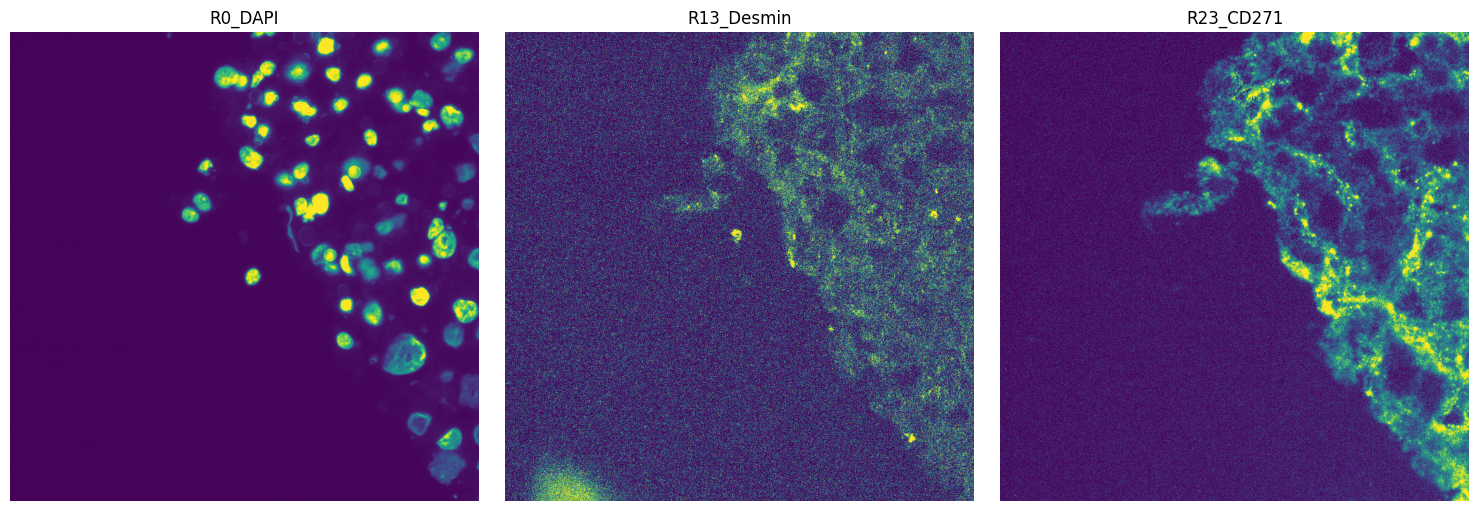

In [5]:
# or using spatialdata-plot:
import numpy as np
import dask.array as da
from matplotlib.colors import Normalize

subset_channels = ["R0_DAPI", "R13_Desmin", "R23_CD271"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for _ax, _channel in zip(axes, subset_channels, strict=True):
    # normalization parameters for visualization (underlying image not changed)
    se = hp.im.get_dataarray(sdata, layer="HumanLiverH35")
    _channel_idx = np.where(sdata["HumanLiverH35"].c.data == _channel)[0].item()
    vmax = da.percentile(se.data[_channel_idx].flatten(), q=99).compute()
    norm = Normalize(vmax=vmax, clip=False)

    render_images_kwargs = {"cmap": "viridis", "norm": norm}
    show_kwargs = {"title": _channel, "colorbar": False}
    _ax = hp.pl.plot_sdata(
        sdata,
        img_layer="HumanLiverH35",
        channel=_channel,
        render_images_kwargs=render_images_kwargs,
        show_kwargs=show_kwargs,
        ax=_ax,
    )
    # frameless figure
    _ax.axis("off")

plt.tight_layout()
plt.show()

## 3. Segment using Cellpose


In [6]:
# we first back the spatialdata object to a zarr store:
import os
import tempfile
import uuid

from spatialdata import read_zarr

OUTPUT_DIR = tempfile.gettempdir()

zarr_path = os.path.join(OUTPUT_DIR, f"sdata_{uuid.uuid4()}.zarr")

sdata.write(zarr_path, overwrite=True)
sdata = read_zarr(sdata.path)

In [7]:
import torch
from dask.distributed import Client, LocalCluster

from harpy.image import cellpose_callable

img_layer = "HumanLiverH35"

# Get the DAPI stain, and add it to a new slot.
sdata = hp.im.add_image_layer(
    sdata, arr=sdata[img_layer].sel(c="R0_DAPI").data[None, ...], output_layer="image", overwrite=True
)

if torch.cuda.is_available():
    from dask_cuda import LocalCUDACluster  # pip install dask-cuda

    # One worker per GPU; each worker will be pinned to a single GPU.
    cluster = LocalCUDACluster(
        CUDA_VISIBLE_DEVICES=[0],  # or [0,1],...etc
        n_workers=1,  # 2 if [0,1],...etc
        threads_per_worker=1,
        memory_limit="32GB",
        # local_directory=os.environ.get( "TMPDIR" ),
    )
else:
    # cpu/mps fall back
    from dask.distributed import LocalCluster

    cluster = LocalCluster(
        n_workers=1
        if torch.backends.mps.is_available()
        else 8,  # If mps/cuda device available, it is better to increase chunk size to maximal value that fits on the gpu, and set n_workers to 1.
        # For this dummy example, we only have one chunk, so setting n_workers>1, has no effect.
        threads_per_worker=1,
        memory_limit="32GB",
        # local_directory=os.environ.get( "TMPDIR" ),
    )

client = Client(cluster)

print(client.dashboard_link)

2025-12-02 11:31:42,757 - harpy.image._manager - INFO - Writing results to layer 'image'


http://127.0.0.1:8787/status


In [8]:
# segment the DAPI stain
sdata = hp.im.segment(
    sdata,
    img_layer="image",
    depth=200,
    model=cellpose_callable,
    diameter=50,
    flow_threshold=0.8,
    cellprob_threshold=-4,
    output_labels_layer="segmentation_mask",
    output_shapes_layer="segmentation_mask_boundaries",
    overwrite=True,
)

client.close()

/Users/arnedf/VIB/harpy/.venv_harpy_1_12_25/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
pretrained model /Users/arnedf/.cellpose/models/cpsam not found, using default model
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
Resizing is deprecated in v4.0.1+
2025-12-02 11:31:55,921 - harpy.image.segmentation._segmentation - INFO - Linking labels across chunks.
2025-12-02 11:31:55,924 - harpy.image._manager - INFO - Writing results to layer 'segmentation_mask'
no parent found for <ome_zarr.reader.Label object at 0x3704dcbc0>: None
2025-12-02 11:31:56,139 - harpy.shape._manager - INFO - Finished vectorizing. Dissol

## 4. Visualize resulting segmentation


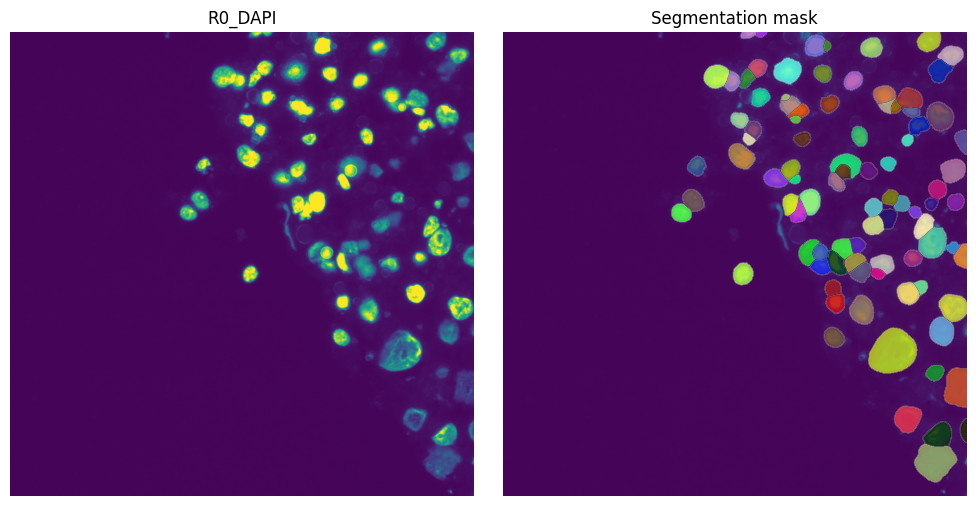

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

channel = "R0_DAPI"
# normalization parameters for visualization (underlying image not changed)
se = hp.im.get_dataarray(sdata, layer="HumanLiverH35")
channel_idx = np.where(sdata["HumanLiverH35"].c.data == channel)[0].item()
vmax = da.percentile(se.data[channel_idx].flatten(), q=99).compute()
norm = Normalize(vmax=vmax, clip=False)

render_images_kwargs = {"cmap": "viridis", "norm": norm}
render_labels_kwargs = {"fill_alpha": 0.6, "outline_alpha": 0.4}
show_kwargs = {"title": channel, "colorbar": False}
_ax = hp.pl.plot_sdata(
    sdata,
    img_layer="HumanLiverH35",
    channel=channel,
    render_images_kwargs=render_images_kwargs,
    show_kwargs=show_kwargs,
    ax=axes[0],
)
_ax.axis("off")

show_kwargs = {"title": "Segmentation mask", "colorbar": False}
_ax = hp.pl.plot_sdata(
    sdata,
    img_layer="HumanLiverH35",
    labels_layer="segmentation_mask",
    channel=channel,
    render_images_kwargs=render_images_kwargs,
    render_labels_kwargs=render_labels_kwargs,
    show_kwargs=show_kwargs,
    ax=axes[1],
)
_ax.axis("off")

plt.tight_layout()
plt.show()

## 5. Feature extraction

Now we have the location of the cells, we can try to extract features from the image to represent the expression of each cell for the marker. There are many different ways to summarize the signal to a single value. When working on spatial proteomics, it is common to use the mean intensity of the pixels in the cell instead of e.g. the count of transcripts. The mean intensity is a simple and fast way to summarize the signal, but it can be sensitive to noise. A more robust way is to use a quantile normalization first to remove intensity outliers and then calculate the mean intensity. Note that we expect the whole-slide image to be already corrected for illumination and background.

You should inspect the normalized images for each channel, as rare or abundant markers may have different distributions and need different q_min and q_max values, which `harpy.im.normalize` supports.


In [10]:
sdata = hp.im.normalize(
    sdata, img_layer="HumanLiverH35", output_layer="HumanLiverH35_normalized_image", q_min=5, q_max=95
)
sdata

2025-12-02 11:31:56,906 - harpy.image._manager - INFO - Writing results to layer 'HumanLiverH35_normalized_image'


SpatialData object, with associated Zarr store: /private/var/folders/q5/7yhs0l6d0x771g7qdbhvkvmr0000gp/T/sdata_2d83d044-84a2-486a-9a1c-460eb79db654.zarr
├── Images
│     ├── 'HumanLiverH35': DataArray[cyx] (151, 1000, 1000)
│     ├── 'HumanLiverH35_normalized_image': DataArray[cyx] (151, 1000, 1000)
│     └── 'image': DataArray[cyx] (1, 1000, 1000)
├── Labels
│     └── 'segmentation_mask': DataArray[yx] (1000, 1000)
└── Shapes
      └── 'segmentation_mask_boundaries': GeoDataFrame shape: (92, 1) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        HumanLiverH35 (Images), HumanLiverH35_normalized_image (Images), image (Images), segmentation_mask (Labels), segmentation_mask_boundaries (Shapes)

Calculating the features for every cell is an intensive process and can take some time. For this small example of 70 cells and 10 channels it takes one second; for 51 channels, it takes around 3 seconds.

In [11]:
sdata = hp.tb.allocate_intensity(
    sdata,
    img_layer="HumanLiverH35_normalized_image",
    labels_layer="segmentation_mask",
    output_layer="table_intensities",
    mode="mean",
    obs_stats="var",
    channels=markers_of_interest[:9],
)
sdata

/Users/arnedf/VIB/harpy/src/harpy/table/_allocation_intensity.py:320: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  adata.obsm[spatial_key] = coordinates
/Users/arnedf/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/arnedf/VIB/harpy/.venv_harpy_1_12_25/lib/python3.12/site-packages/spatialdata/_core/spatialdata.py:178: UserWarning: The table is annotating 'segmentation_mask', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


SpatialData object, with associated Zarr store: /private/var/folders/q5/7yhs0l6d0x771g7qdbhvkvmr0000gp/T/sdata_2d83d044-84a2-486a-9a1c-460eb79db654.zarr
├── Images
│     ├── 'HumanLiverH35': DataArray[cyx] (151, 1000, 1000)
│     ├── 'HumanLiverH35_normalized_image': DataArray[cyx] (151, 1000, 1000)
│     └── 'image': DataArray[cyx] (1, 1000, 1000)
├── Labels
│     └── 'segmentation_mask': DataArray[yx] (1000, 1000)
├── Shapes
│     └── 'segmentation_mask_boundaries': GeoDataFrame shape: (92, 1) (2D shapes)
└── Tables
      └── 'table_intensities': AnnData (92, 9)
with coordinate systems:
    ▸ 'global', with elements:
        HumanLiverH35 (Images), HumanLiverH35_normalized_image (Images), image (Images), segmentation_mask (Labels), segmentation_mask_boundaries (Shapes)

In [12]:
display(sdata["table_intensities"].to_df().head())
display(sdata["table_intensities"].obs.head())

channels,R1_VSIG4,R1_CD14,R2_CD163,R3_CD11c,R3_CD335,R4_CD141,R5_CD169,R5_CD49d,R6_CD279
cells,,,,,,,,,
38_segmentation_mask_fc2a4c1f,0.809246,0.005399,0.071420,0.025679,0.012487,0.031609,0.029887,0.011253,0.029230
39_segmentation_mask_fc2a4c1f,0.825022,0.004294,0.059946,0.024327,0.012186,0.034624,0.032157,0.011942,0.026835
41_segmentation_mask_fc2a4c1f,0.877863,0.007805,0.081679,0.035323,0.015345,0.035432,0.039999,0.019946,0.031082
42_segmentation_mask_fc2a4c1f,0.848713,0.012056,0.074464,0.027920,0.014975,0.035241,0.030530,0.024061,0.031432
44_segmentation_mask_fc2a4c1f,0.859654,0.007509,0.068396,0.031179,0.011344,0.032872,0.028308,0.008651,0.031429


,cell_ID,fov_labels,var_R1_VSIG4,var_R1_CD14,var_R2_CD163,var_R3_CD11c,var_R3_CD335,var_R4_CD141,var_R5_CD169,var_R5_CD49d,var_R6_CD279
cells,,,,,,,,,,,
38_segmentation_mask_fc2a4c1f,38,segmentation_mask,0.003558,0.000077,0.003782,0.001358,0.000190,0.001706,0.001508,0.000237,0.001325
39_segmentation_mask_fc2a4c1f,39,segmentation_mask,0.002957,0.000052,0.002421,0.001080,0.000181,0.001609,0.001677,0.000137,0.000967
41_segmentation_mask_fc2a4c1f,41,segmentation_mask,0.002206,0.000139,0.003784,0.001849,0.000250,0.001627,0.002103,0.000471,0.001306
42_segmentation_mask_fc2a4c1f,42,segmentation_mask,0.002137,0.000269,0.003635,0.001498,0.000212,0.001648,0.001351,0.001127,0.001332
44_segmentation_mask_fc2a4c1f,44,segmentation_mask,0.002218,0.000121,0.003330,0.001597,0.000186,0.001543,0.001294,0.000126,0.001379


We also can extract geometric and morphological information based on the shape of the cells and append it as extra observations to our table. This can be useful to distinguish between different cell types. For example, we can calculate the area of the cell, the perimeter, the eccentricity, the solidity, the major and minor axis.


In [13]:
sdata = hp.tb.add_regionprop_features(
    sdata,
    labels_layer="segmentation_mask",
    table_layer="table_intensities",
    output_layer="table_intensities",
    properties=["area", "perimeter", "eccentricity"],
    overwrite=True,
)
sdata["table_intensities"]

/Users/arnedf/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
2025-12-02 11:32:02,519 - harpy.utils._io - WARNING - layer with name 'table_intensities' already exists. Overwriting...


AnnData object with n_obs × n_vars = 92 × 9
    obs: 'cell_ID', 'fov_labels', 'var_R1_VSIG4', 'var_R1_CD14', 'var_R2_CD163', 'var_R3_CD11c', 'var_R3_CD335', 'var_R4_CD141', 'var_R5_CD169', 'var_R5_CD49d', 'var_R6_CD279', 'area', 'perimeter', 'eccentricity'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

In [14]:
sdata["table_intensities"].obs.head()

,cell_ID,fov_labels,var_R1_VSIG4,var_R1_CD14,var_R2_CD163,var_R3_CD11c,var_R3_CD335,var_R4_CD141,var_R5_CD169,var_R5_CD49d,var_R6_CD279,area,perimeter,eccentricity
cells,,,,,,,,,,,,,,
38_segmentation_mask_fc2a4c1f,38,segmentation_mask,0.003558,0.000077,0.003782,0.001358,0.000190,0.001706,0.001508,0.000237,0.001325,418.0,87.798990,0.911566
39_segmentation_mask_fc2a4c1f,39,segmentation_mask,0.002957,0.000052,0.002421,0.001080,0.000181,0.001609,0.001677,0.000137,0.000967,224.0,60.177670,0.854401
41_segmentation_mask_fc2a4c1f,41,segmentation_mask,0.002206,0.000139,0.003784,0.001849,0.000250,0.001627,0.002103,0.000471,0.001306,1832.0,161.053824,0.625884
42_segmentation_mask_fc2a4c1f,42,segmentation_mask,0.002137,0.000269,0.003635,0.001498,0.000212,0.001648,0.001351,0.001127,0.001332,1630.0,158.539105,0.518932
44_segmentation_mask_fc2a4c1f,44,segmentation_mask,0.002218,0.000121,0.003330,0.001597,0.000186,0.001543,0.001294,0.000126,0.001379,1679.0,153.539105,0.434846


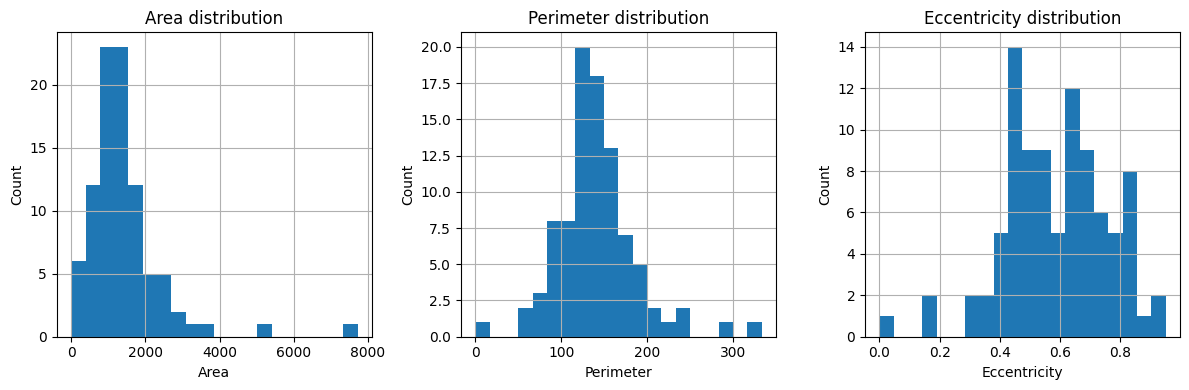

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
sdata["table_intensities"].obs["area"].hist(bins=20, ax=axes[0])
axes[0].set_xlabel("Area")
axes[0].set_ylabel("Count")
axes[0].set_title("Area distribution")
sdata["table_intensities"].obs["perimeter"].hist(bins=20, ax=axes[1])
axes[1].set_xlabel("Perimeter")
axes[1].set_ylabel("Count")
axes[1].set_title("Perimeter distribution")
sdata["table_intensities"].obs["eccentricity"].hist(bins=20, ax=axes[2])
axes[2].set_xlabel("Eccentricity")
axes[2].set_ylabel("Count")
axes[2].set_title("Eccentricity distribution")
plt.tight_layout()
plt.show()

We can spatially visualize both the mean intensity of a given channel and any column from the `.obs` attribute of the `AnnData` table `'table_intensities'` (which is annotated by the labels layer `'segmentation_mask'`).

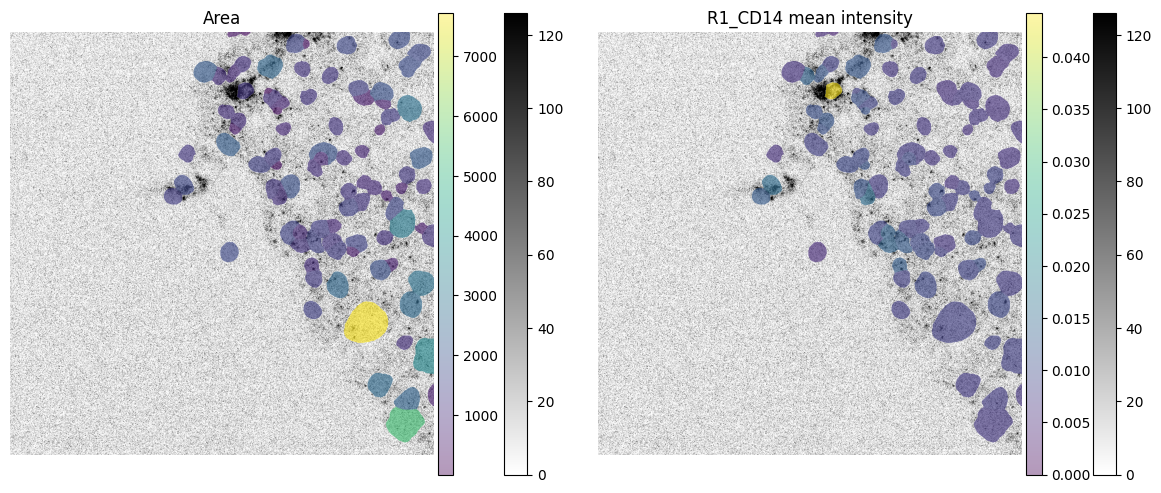

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

channel = "R1_CD14"
# normalization parameters for visualization (underlying image not changed)
se = hp.im.get_dataarray(sdata, layer="HumanLiverH35")
channel_idx = np.where(sdata["HumanLiverH35"].c.data == channel)[0].item()
vmax = da.percentile(se.data[channel_idx].flatten(), q=99).compute()
norm = Normalize(vmax=vmax, clip=False)

render_images_kwargs = {"cmap": "binary", "norm": norm}
render_labels_kwargs = {"fill_alpha": 0.6, "outline_alpha": 0.4}

# color by area
color = "area"
show_kwargs = {
    "title": "Area",
    "colorbar": True,
}
ax = hp.pl.plot_sdata(
    sdata,
    img_layer="HumanLiverH35",
    channel=channel,
    labels_layer="segmentation_mask",
    table_layer="table_intensities",
    color=color,
    render_images_kwargs=render_images_kwargs,
    show_kwargs=show_kwargs,
    ax=axes[0],
)
ax.axis("off")

# color by mean intensity
color = channel
show_kwargs = {
    "title": f"{color} mean intensity",
    "colorbar": True,
}
ax = hp.pl.plot_sdata(
    sdata,
    img_layer="HumanLiverH35",
    channel=channel,
    labels_layer="segmentation_mask",
    table_layer="table_intensities",
    color=color,
    render_images_kwargs=render_images_kwargs,
    show_kwargs=show_kwargs,
    ax=axes[1],
)
ax.axis("off")

plt.tight_layout()
plt.show()

## 6. Leiden clustering on mean intensity values

Note that for this dummy example leiden clustering will not be very informative.


In [17]:
cluster_key = "leiden"

sdata = hp.tb.leiden(
    sdata,
    labels_layer="segmentation_mask",
    table_layer="table_intensities",
    output_layer="table_intensities",
    key_added=cluster_key,
    overwrite=True,
)

2025-12-02 11:32:07,405 - harpy.utils._io - WARNING - layer with name 'table_intensities' already exists. Overwriting...


(np.float64(0.0), np.float64(1000.0), np.float64(1000.0), np.float64(0.0))

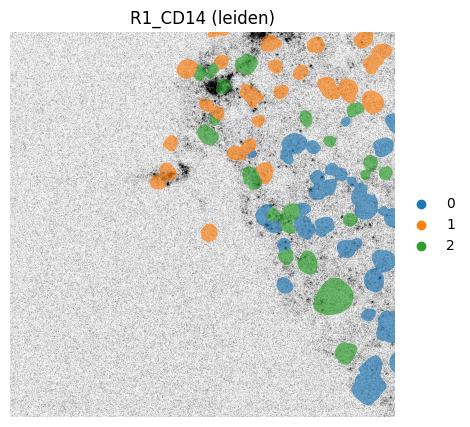

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

channel = "R1_CD14"
# normalization parameters for visualization (underlying image not changed)
se = hp.im.get_dataarray(sdata, layer="HumanLiverH35")
channel_idx = np.where(sdata["HumanLiverH35"].c.data == channel)[0].item()
vmax = da.percentile(se.data[channel_idx].flatten(), q=99).compute()
norm = Normalize(vmax=vmax, clip=False)

render_images_kwargs = {"cmap": "binary", "norm": norm}
render_labels_kwargs = {"fill_alpha": 0.6, "outline_alpha": 0.4}

# color by area
color = cluster_key
show_kwargs = {
    "title": f"{channel} ({color})",
    "colorbar": False,
}
ax = hp.pl.plot_sdata(
    sdata,
    img_layer="HumanLiverH35",
    channel=channel,
    labels_layer="segmentation_mask",
    table_layer="table_intensities",
    color=color,
    render_images_kwargs=render_images_kwargs,
    show_kwargs=show_kwargs,
    ax=ax,
)
ax.axis("off")

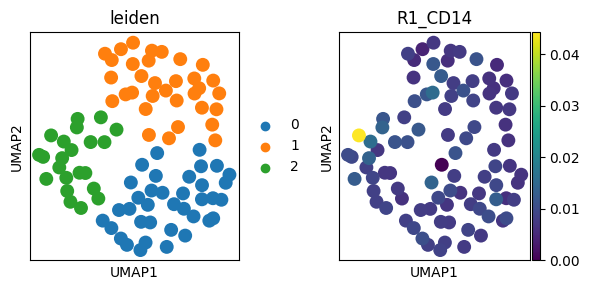

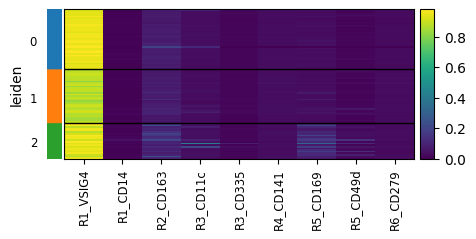

In [19]:
# visualize with scanpy
import scanpy as sc

fig, axes = plt.subplots(1, 2, figsize=(6, 3))

sc.pl.umap(sdata["table_intensities"], color=cluster_key, ax=axes[0], show=False, size=400)
sc.pl.umap(sdata["table_intensities"], color="R1_CD14", ax=axes[1], show=False, size=400)
plt.tight_layout()
plt.show()

sc.pl.heatmap(
    sdata["table_intensities"],
    var_names=sdata["table_intensities"].var_names,
    groupby=cluster_key,
    swap_axes=False,
    norm=None,
    figsize=(5, 2),
)

We can also calculate the mean intensity per leiden cluster.

2025-12-02 11:32:08,732 - harpy.table._cluster_intensity - INFO - Weighted (by instance size) average intensity per cluster (cluster key: 'leiden') will be stored in 'sdata[table_intensities].uns[leiden_weighted_intensity]'.
2025-12-02 11:32:08,737 - harpy.table._cluster_intensity - WARNING - Column with name 'shapeSize' not found in 'sdata[table_intensities].obs', calculating instance size for all instances in ['segmentation_mask'].
2025-12-02 11:32:08,738 - harpy.table._cluster_intensity - INFO - Calculating instance size from provided labels layer 'segmentation_mask'
/Users/arnedf/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/arnedf/VIB/harpy/.venv_harpy_1_12_25/lib/python3.12/site-packages/spatialdata/models/models.py:1183: UserWarning: Converting `region_key: fov_labels` to categorical dtype.
  convert_region_column_to_catego

,leiden,R1_VSIG4,R1_CD14,R2_CD163,R3_CD11c,R3_CD335,R4_CD141,R5_CD169,R5_CD49d,R6_CD279
0,0,0.954299,0.008362,0.074432,0.034132,0.014923,0.032243,0.035451,0.015137,0.028149
1,1,0.881405,0.008194,0.076958,0.036107,0.014672,0.034221,0.036067,0.017595,0.030097
2,2,0.943359,0.010718,0.125161,0.060092,0.017172,0.033411,0.119459,0.036574,0.029185


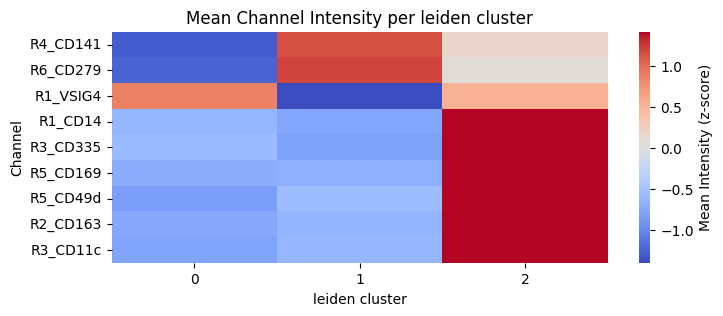

In [20]:
# calculate the mean itensity per leiden cluster
sdata = hp.tb.cluster_intensity(
    sdata,
    table_layer="table_intensities",
    labels_layer="segmentation_mask",
    output_layer="table_intensities",
    cluster_key=cluster_key,
    cluster_key_uns=f"{cluster_key}_weighted_intensity",
    overwrite=True,
)

display(sdata["table_intensities"].uns[f"{cluster_key}_weighted_intensity"])

ax = hp.pl.cluster_intensity_heatmap(
    sdata, table_layer="table_intensities", cluster_key="leiden", z_score=True, figsize=(8, 3)
)